<a href="https://colab.research.google.com/github/AamirKhaan/Student-Academic-Performance/blob/master/12_Boosting_AdaBoostClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="background-color:Aqua; padding:20px; border-radius:10px">Boosting AdaBoost Classifier</h1>

## Overview      

<div style="background-color:Gainsboro; padding:20px; text-align:justify; font-weight: bold">
    <p>In this section following steps are performed: </p>
    <ol>
        <li>Data Preparation and Encoding</li>
        <li>Preliminary AdaBoost Classifier</li>
        <li>AdaBoost Classifier Optimization with Number of estimators</li>
        <li>AdaBoost Classifier with optimized Number of estimators</li>
        <li>Repeated Stratified k-Fold Cross Validation</li>
        <li>Model Learning Curve</li>
    </ol>
</div>


### Standard Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

In [2]:
# Jupyter Noteboook Configurations (personal prefrences)
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', None)
sns.set() 

In [3]:
# Global parameters for figure
plt.rcParams["figure.figsize"] = [10.00, 8.00]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.autolayout"] = True

### 1. Data Preparation and Encoding

#### 1.1 Import Modified Data

In [4]:
# Import the Student's data from local storage
# ! Dont' run the cell in colab
data_df = pd.read_csv('./data/xAPI-Edu-Data_modified.csv')

In [5]:
# Import the Student's data from github storage
# Run only in colab
url = 'https://raw.githubusercontent.com/AamirKhaan/Student-Academic-Performance/main/data/xAPI-Edu-Data_modified.csv'
data_df = pd.read_csv(url)

In [6]:
# Selected Features
CATEGORICAL_FEATURES = ['stage_id','relation', 'parent_answering_survey', 
                            'parent_school_satisfaction','student_absence_days']
NUMERICAL_FEATURES = ['raised_hands', 'visited_resources', 'announcements_view', 'discussion']
TARGET = ['class']

In [7]:
# Optimize Data Type for efficent memory utilization
for feature in CATEGORICAL_FEATURES:
    data_df[feature] = data_df[feature].astype('category')
    
for feature in NUMERICAL_FEATURES:
    data_df[feature] = data_df[feature].astype('int8')

data_df[TARGET] = data_df[TARGET].astype('category')

#### 1.2 Encode Data

In [8]:
# Input Features Encoding
categorical_encoder = OrdinalEncoder(dtype='int8')
categorical_ds  = categorical_encoder.fit_transform(data_df[CATEGORICAL_FEATURES])
categorical_encoded = pd.DataFrame(categorical_ds, columns=CATEGORICAL_FEATURES, dtype='int8')
# Target Encoding
target_encoder = LabelEncoder()
target_ds = target_encoder.fit_transform(data_df[TARGET])
target_encoded = pd.DataFrame(target_ds, columns=TARGET, dtype='int8')
# Combine the Data
encoded_df = pd.concat([categorical_encoded,data_df[NUMERICAL_FEATURES]], axis=1)

### 2.  Preliminary AdaBoost Classifier

In [9]:
X = encoded_df
y = target_encoded

In [10]:
# Test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [11]:
# AdaBoost Classifier
clf = AdaBoostClassifier(algorithm='SAMME',random_state=42)

#### 2.1 Model Parameters

In [12]:
# Model parameters
clf.get_params()

{'algorithm': 'SAMME',
 'base_estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': 42}

In [13]:
# Train the model
clf = clf.fit(X_train, y_train)

#### 2.3 Model Scores

In [14]:
# Test Accuracy
y_hat = clf.predict(X_test)
initial_test_accuracy = accuracy_score(y_test, y_hat)
print(f'Preliminary AdaBoost Classifier Test Accuracy: {initial_test_accuracy*100}')
# Train Accuracy
predictions_train = clf.predict(X_train)
initial_train_accuracy = accuracy_score(y_train, predictions_train)
print(f'Preliminary AdaBoost Classifier Train Accuracy: {initial_train_accuracy*100}')

Preliminary AdaBoost Classifier Test Accuracy: 73.41772151898735
Preliminary AdaBoost Classifier Train Accuracy: 74.6875


<div style="background-color:Gainsboro; padding:20px; text-align:justify; ">
<p>The accuracy of the model on Training Data (74.69%) and the accuracy on Test Data (73.42%).</p>
</div>

#### 2.4 Confusion Matrix

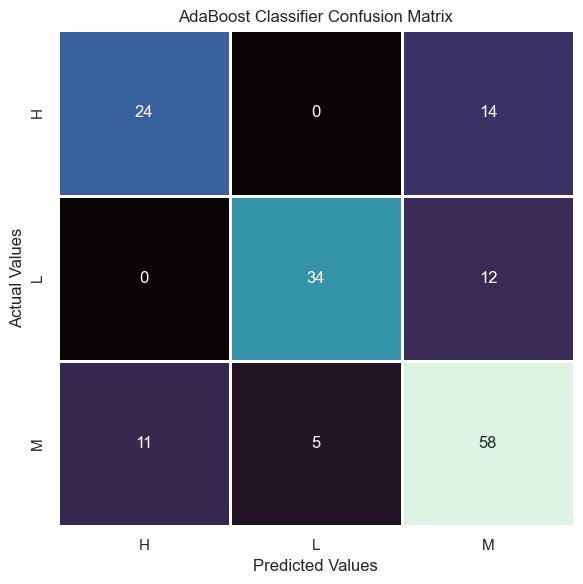

In [15]:
cm_df = pd.DataFrame(confusion_matrix(y_test, y_hat),
                     index = ['H','L','M'], 
                     columns = ['H','L','M'])

fig = plt.figure(figsize=(6,6))
sns.heatmap(cm_df, annot=True, cmap='mako',cbar=False,linewidth=1)
plt.title('AdaBoost Classifier Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

#### 2.5 Classification Report

In [16]:
print('AdaBoost Classifier Report\n')
print(classification_report(y_test,y_hat, target_names=['H','L','M']))

AdaBoost Classifier Report

              precision    recall  f1-score   support

           H       0.69      0.63      0.66        38
           L       0.87      0.74      0.80        46
           M       0.69      0.78      0.73        74

    accuracy                           0.73       158
   macro avg       0.75      0.72      0.73       158
weighted avg       0.74      0.73      0.73       158



### 3. AdaBoost Classifier Optimization with Number of estimators

In [17]:
n_estimators = np.arange(50,810,10)

clf_boosting = []
for n in n_estimators :
    clf = AdaBoostClassifier(n_estimators = n, algorithm='SAMME', random_state=42)
    clf.fit(X_train, y_train)
    clf_boosting.append(clf)

train_scores = [clf.score(X_train,y_train) for clf in clf_boosting]
test_scores = [clf.score(X_test,y_test) for clf in clf_boosting]

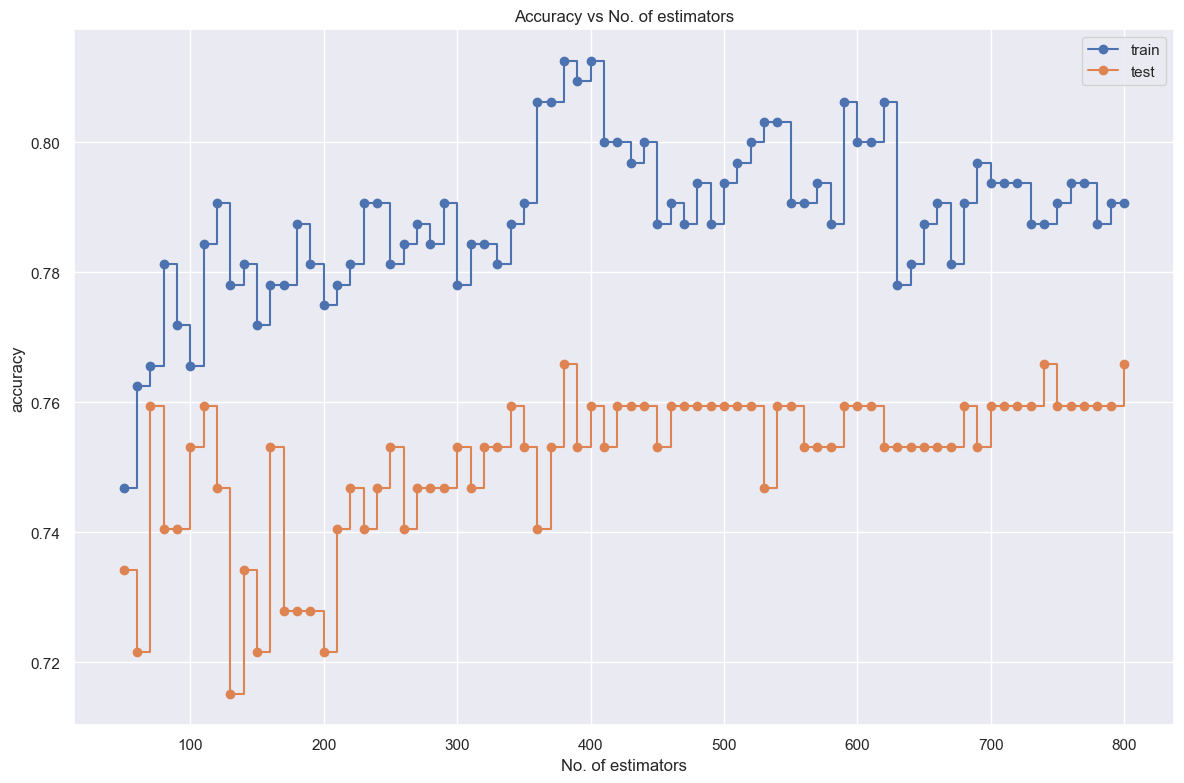

In [18]:
plt.rcParams["figure.figsize"] = [12.00, 8.00]
fig, ax = plt.subplots()
ax.set_xlabel('No. of estimators')
ax.set_ylabel('accuracy')
ax.set_title('Accuracy vs No. of estimators')
ax.plot(n_estimators , train_scores, marker='o', label='train', drawstyle='steps-post')
ax.plot(n_estimators , test_scores, marker='o', label='test', drawstyle='steps-post')
ax.legend()
plt.show()

<div style="background-color:Gainsboro; padding:20px; text-align:justify;">
<p>The graph of accuracy vs No. of estimators show the variation in the accuracy with respect to No. of estimators in Training and Test data. The highest accuracy in test data is when the number of estimators are 380.</p>
</div>

In [21]:
# Get the index of the peak accuracy on the test data
index_max = test_scores.index(max(test_scores))

### 4. AdaBoost Classifier with optimized Number of estimators

#### 4.1 Optimized AdaBoost Classifier Parameters

In [22]:
clf_boosting[index_max].get_params()

{'algorithm': 'SAMME',
 'base_estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 380,
 'random_state': 42}

#### 4.2 Optimized AdaBoost Classifier Scores

In [23]:
# Test Accuracy
opt_y_test = clf_boosting[index_max].predict(X_test)
opt_test_accuracy = accuracy_score(y_test, opt_y_test)
print(f'Optimized AdaBoost Test Accuracy: {opt_test_accuracy*100}')
# Train Accuracy
opt_y_train = clf_boosting[index_max].predict(X_train)
opt_train_accuracy = accuracy_score(y_train, opt_y_train)
print(f'Optimized AdaBoost Train Accuracy: {opt_train_accuracy*100}')

Optimized AdaBoost Test Accuracy: 76.58227848101265
Optimized AdaBoost Train Accuracy: 81.25


<div style="background-color:Gainsboro; padding:20px; text-align:justify; ">
<p>The accuracy of the optimized model on Training Data (81.25%) greater than the accuracy on Test Data (76.58%). The model shows acceptable performance. </p>
</div>

#### 4.3 Optimized AdaBoost Classifier Confusion Matrix

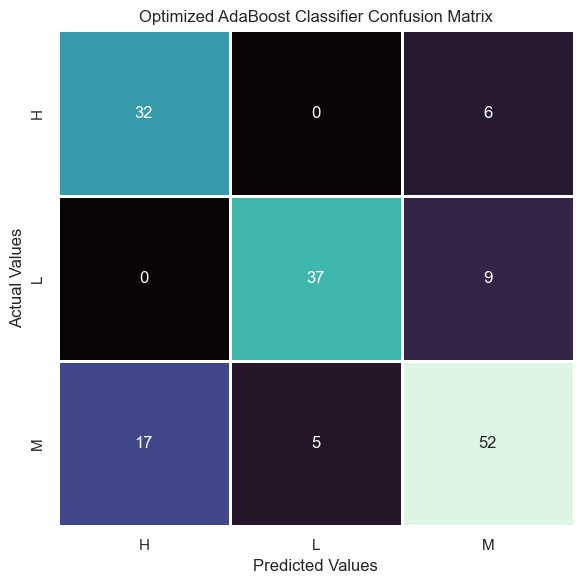

In [24]:
ocm_df = pd.DataFrame(confusion_matrix(y_test, opt_y_test),
                     index = ['H','L','M'], 
                     columns = ['H','L','M'])

fig = plt.figure(figsize=(6,6))
sns.heatmap(ocm_df, annot=True, cmap='mako',cbar=False,linewidth=1)
plt.title('Optimized AdaBoost Classifier Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

#### 4.4 Optimized AdaBoost Classification report

In [25]:
print('Optimized AdaBoost Classifier Report\n')
print(classification_report(y_test,opt_y_test, target_names=['H','L','M']))

Optimized AdaBoost Classifier Report

              precision    recall  f1-score   support

           H       0.65      0.84      0.74        38
           L       0.88      0.80      0.84        46
           M       0.78      0.70      0.74        74

    accuracy                           0.77       158
   macro avg       0.77      0.78      0.77       158
weighted avg       0.78      0.77      0.77       158



### 5. Repeated Stratified k-Fold Cross Validation

In [26]:
# Model
clf_cv = AdaBoostClassifier(n_estimators = 380, algorithm='SAMME', random_state=42)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

scores = cross_val_score(clf_cv, X_train, y_train, scoring='accuracy', cv = cv, n_jobs=-1)

# Performance
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean Accuracy: 0.706 (0.076)


### 6. Model Learning Curve

In [27]:
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=42)
estimator = AdaBoostClassifier(n_estimators = 380, algorithm='SAMME', random_state=42)

train_sizes=np.linspace(0.1, 1.0, 5)

train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=-1,
        train_sizes=train_sizes,
        return_times=True,
    )

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

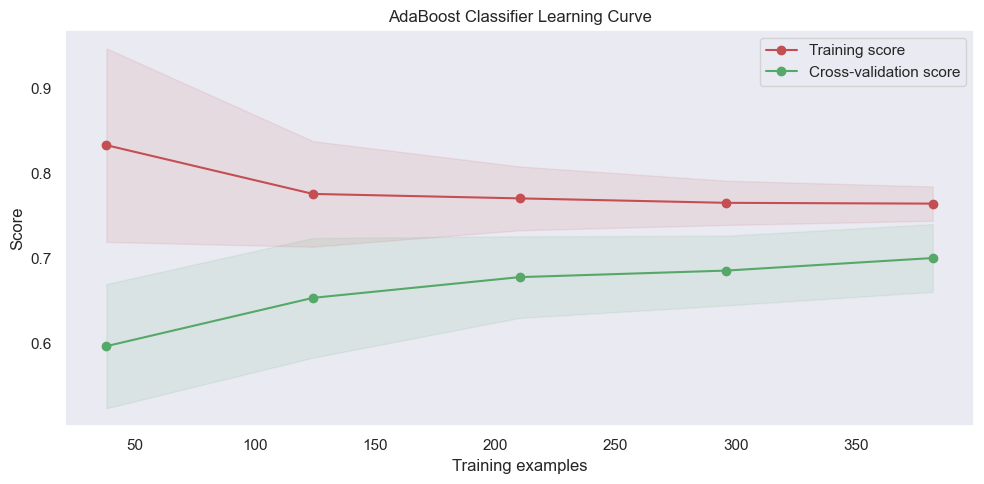

In [28]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('AdaBoost Classifier Learning Curve')
ax.set_xlabel("Training examples")
ax.set_ylabel("Score")
# Plot learning curve
ax.grid()
ax.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",)

ax.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",)
    
ax.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")   
ax.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")   
ax.legend(loc="best");

## Observations
  
The key observations are:  
   
1. The Preliminary AdaBosst Classifier has:     
    a. Test Accuracy of 73.42%     
    b. Train Accuracy of 74.69%     
2. Optimization by varying number of esimators (380) results in highest accuracy of 76.58%.
3. The Optimized AdaBoost Classifier has:   
    a. Test Accuracy of 76.58%     
    b. Train Accuracy of 81.25%    
4. The 10 Fold Cross Validation fo the Base Decision Tree relusted in Mean Accuracy of 70.6%.

## Conclusion
Based on the obervations:

1. The Optimized AdaBoost Classifier produced the maximum test accuracy of 76.58%.
2. The Cross Validation produced mean accuracy of 70.6% that show the model is quite well trained and have acceptable performance.